#**Image-to-Image Translation Using Conditional DCGANs !!!**

This notebook contain the implemented "Image-to-Image Translation Using Conditional DCGANs" based on the paper called "Image-to-Image Translation with Conditional Adversarial Networks"

L1 loss has been used in the loss function


In [0]:
from google.colab import drive
drive.mount('/content/gdrive')  ## (sync .gcp)

from google.colab import files
uploaded = files.upload()

!mkdir ~/.kaggle
!cp /content/kaggle.json ~/.kaggle/kaggle.json

!kaggle datasets download -d vikramtiwari/pix2pix-dataset
!unzip \*.zip  && rm *.zip
!apt-get install tree

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


Streaming output truncated to the last 5000 lines.
  inflating: edges2shoes/edges2shoes/train/8216_AB.jpg  
  inflating: edges2shoes/edges2shoes/train/8217_AB.jpg  
  inflating: edges2shoes/edges2shoes/train/8218_AB.jpg  
  inflating: edges2shoes/edges2shoes/train/8219_AB.jpg  
  inflating: edges2shoes/edges2shoes/train/821_AB.jpg  
  inflating: edges2shoes/edges2shoes/train/8220_AB.jpg  
  inflating: edges2shoes/edges2shoes/train/8221_AB.jpg  
  inflating: edges2shoes/edges2shoes/train/8222_AB.jpg  
  inflating: edges2shoes/edges2shoes/train/8223_AB.jpg  
  inflating: edges2shoes/edges2shoes/train/8224_AB.jpg  
  inflating: edges2shoes/edges2shoes/train/8225_AB.jpg  
  inflating: edges2shoes/edges2shoes/train/8226_AB.jpg  
  inflating: edges2shoes/edges2shoes/train/8227_AB.jpg  
  inflating: edges2shoes/edges2shoes/train/8228_AB.jpg  
  inflating: edges2shoes/edges2shoes/train/8229_AB.jpg  
  inflating: edges2shoes/edges2shoes/train/822_AB.jpg  
  inflating: edges2shoes/edges2shoes/tr

In [0]:
import os,shutil
import pandas as pd
import torch
import numpy as np
from torch import nn
from torchsummary import summary
import torchvision
from torchvision import datasets
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Create DataLoaders

In [0]:
class get_dataset(torch.utils.data.Dataset):
  def __init__(self,name='edges2shoes',type_='train',transform=None):
    self.dir_=name+'/'+name+'/'+type_
    self.img_list=sorted(os.listdir(self.dir_))
    self.transform=transform
  def __len__(self):
    return len(self.img_list)
  def __getitem__(self,idx):
    both=plt.imread(self.dir_+'/'+self.img_list[idx]).astype('uint8')
    x=both[:,:both.shape[1]//2,:]
    y=both[:,both.shape[1]//2:,:]
    x,y=self.transform(Image.fromarray(x)),self.transform(Image.fromarray(y))
    return x,y    

In [0]:
img_size=128
batch_size=32

my_transform=transforms.Compose([transforms.Resize((img_size,img_size)),transforms.ToTensor()])

name='cityscapes'
dataset=get_dataset(name=name,transform=my_transform)

dataloader=torch.utils.data.DataLoader(dataset,batch_size=batch_size,shuffle=True,drop_last=True)

## Create the Model Architecture



In [0]:
class conv_block(nn.Module):
  def __init__(self,in_channels,out_channels,kernel_size=4,stride=2,padding=1):
    super(conv_block,self).__init__()
    self.conv_block=nn.Sequential(
        nn.Conv2d(in_channels,out_channels,kernel_size,stride,padding),
        nn.LeakyReLU(0.2),
        nn.BatchNorm2d(out_channels)
    )  
  def forward(self,x):
    return self.conv_block(x)

class transconv_block(nn.Module):
  def __init__(self,in_channels,out_channels,kernel_size=4,stride=2,padding=1):
    super(transconv_block,self).__init__()
    self.transconv_block=nn.Sequential(
        nn.ConvTranspose2d(in_channels,out_channels,kernel_size,stride,padding),
        nn.ReLU(),
        nn.BatchNorm2d(out_channels)
    )
  def forward(self,x):
    return self.transconv_block(x)

###1. Generator

In [0]:
# for 128,128 size
class Generator(nn.Module):
  def __init__(self):
    super(Generator,self).__init__()

    self.enc_layer1=conv_block(4,8)
    self.enc_layer2=conv_block(8,16)
    self.enc_layer3=conv_block(16,32)
    self.enc_layer4=conv_block(32,64)
    self.enc_layer5=conv_block(64,128)
    self.bottleneck=conv_block(128,256,kernel_size=4,stride=1,padding=0)

    self.dec_layer1=transconv_block(256,128,kernel_size=4,stride=1,padding=0)
    self.dec_layer2=transconv_block(256,64)
    self.dec_layer3=transconv_block(128,32)
    self.dec_layer4=transconv_block(64,16)
    self.dec_layer5=transconv_block(32,8)
    self.dec_layer6=transconv_block(16,3)
    self.dec_layer7=nn.ConvTranspose2d(6,3,kernel_size=1,stride=1,padding=0)

  def forward(self,x,z):
    z=z.view(-1,1,128,128)
    x=x.view(-1,3,128,128)
    x_noisy=torch.cat([z,x],1)
    enc1=self.enc_layer1(x_noisy)
    enc2=self.enc_layer2(enc1)
    enc3=self.enc_layer3(enc2)
    enc4=self.enc_layer4(enc3)
    enc5=self.enc_layer5(enc4)
    latent=self.bottleneck(enc5)
    dec1=torch.cat([self.dec_layer1(latent),enc5],1)
    dec2=torch.cat([self.dec_layer2(dec1),enc4],1)
    dec3=torch.cat([self.dec_layer3(dec2),enc3],1)
    dec4=torch.cat([self.dec_layer4(dec3),enc2],1)
    dec5=torch.cat([self.dec_layer5(dec4),enc1],1)
    dec6=torch.cat([self.dec_layer6(dec5),x],1)
    output=self.dec_layer7(dec6)

    return output

###2. Discriminator 

In [0]:
class Discriminator(nn.Module):
  def __init__(self):
    super(Discriminator,self).__init__()
    self.model=nn.Sequential(
        conv_block(6,8),
        conv_block(8,16),
        conv_block(16,32),
        conv_block(32,64),
        conv_block(64,128),
        nn.Conv2d(128,1,kernel_size=4,stride=1,padding=0),
        nn.Sigmoid()
    )
  def forward(self,x,y):
    x=x.view(-1,3,128,128)
    y=y.view(-1,3,128,128)
    concat=torch.cat([x,y],1)
    out=self.model(concat)
    label=out.view(-1,1)
    return label #real/fake

### Check implemented Generator and Discriminator

In [0]:
from torch.utils.tensorboard import SummaryWriter
import os,shutil
try:
  shutil.rmtree('runs')
except:pass

os.makedirs("runs", exist_ok=True)
writer_gen = SummaryWriter('runs/generator')
writer_dis = SummaryWriter('runs/discriminator')

writer_gen.add_graph(Generator(),[torch.randn((64,3,128,128)),torch.randn((64,1,128,128))])
writer_dis.add_graph(Discriminator(),[torch.randn((64,3,128,128)),torch.randn((64,3,128,128))])  #change this to discriminator

writer_gen.close()
writer_dis.close()


%load_ext tensorboard 
%tensorboard --logdir {'runs'}

##Objective Function

In [0]:
bce=nn.BCELoss().to(device)
L1=nn.L1Loss().to(device)
k=70
def criterion(y_hat,y):
  loss=bce(y_hat,y)+k*L1(y_hat,y)
  return loss

## Initialization

In [0]:
lr=0.0001
D=Discriminator().to(device)
G=Generator().to(device)
opt_D=torch.optim.Adam(D.parameters(),lr=lr)
opt_G=torch.optim.Adam(G.parameters(),lr=lr)
losses_G,losses_D=[],[]

##Load Previously saved models

In [0]:
def load_checkpoint(G,D,losses_G,losses_D):
  G.load_state_dict(torch.load('gdrive/My Drive/pix2pixmodel/G_%s.pth'%name))
  D.load_state_dict(torch.load('gdrive/My Drive/pix2pixmodel/D_%s.pth'%name))
  losses_G+=list(np.load('gdrive/My Drive/pix2pixmodel/Losses_G_%s.npy'%name,allow_pickle=True))
  losses_D+=list(np.load('gdrive/My Drive/pix2pixmodel/Losses_D_%s.npy'%name,allow_pickle=True))

In [0]:
#run this for load latest model and the losses list
load_checkpoint(G,D,losses_G,losses_D)

## Training

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:516: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)
/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:88: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


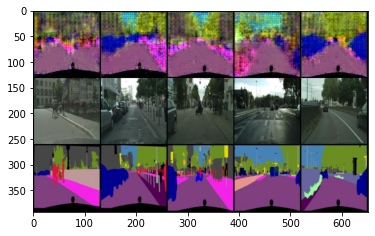

/usr/local/lib/python3.6/dist-packages/torch/storage.py:34: FutureWarning: pickle support for Storage will be removed in 1.5. Use `torch.save` instead
  warnings.warn("pickle support for Storage will be removed in 1.5. Use `torch.save` instead", FutureWarning)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


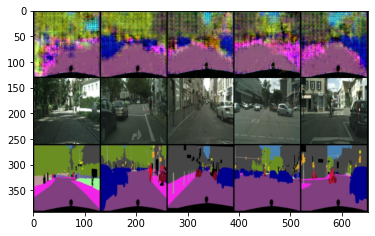

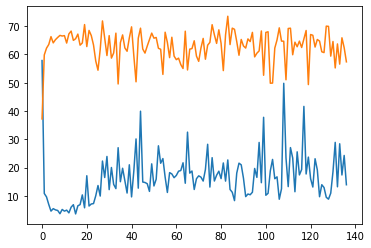

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 110, loss_G: 68.16630554199219, loss_D: 25.55746841430664


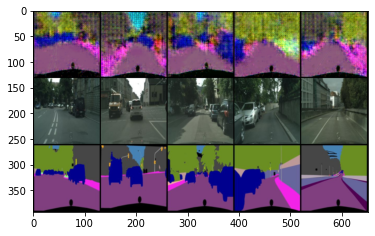

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


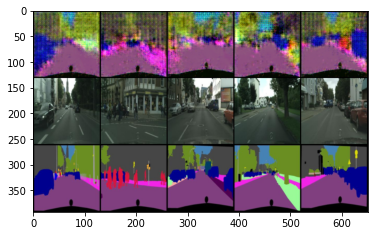

In [0]:
#G(x,z), D(x,y)
factor=1
G.train()
D.train()
for epoch in range(0,500):
  for i,(x,y) in enumerate(dataloader):
    opt_D.zero_grad()
    opt_G.zero_grad()

    x=x.to(device)
    y=y.to(device)
    if i%factor==0:
      #train Discriminator
      #1. for real data
      loss_real=criterion(D(x,y),torch.ones((batch_size,)).to(device)*0.9)

      z=torch.randn((batch_size,1,128,128)).to(device)
      loss_fake=criterion(D(x,G(x,z).detach()),torch.ones((batch_size,)).to(device)*0.1)

      loss_D=loss_real+loss_fake
      loss_D.backward()
      opt_D.step()

    #train Generator
    z=torch.randn((batch_size,1,128,128)).to(device)
    loss_G=criterion(D(x,G(x,z)),torch.ones((batch_size,)).to(device))
    loss_G.backward()
    opt_G.step()
    if i%50==0:
      plt.figure()
      generated_imgs=G(x[:5],z[:5])
      real_imgs=x[:5]
      imgs=torch.cat([generated_imgs,real_imgs,y[:5]],0).data.cpu()
      grid=make_grid(imgs,nrow=5).permute(1,2,0).numpy()
      plt.imshow(grid)
      plt.show()


    if i%100==0:
      losses_D.append(loss_D.data)
      losses_G.append(loss_G.data)


    if i%100==0:      
      torch.save(D.state_dict(), "gdrive/My Drive/pix2pixmodel/D_%s.pth"%name)
      torch.save(G.state_dict(), "gdrive/My Drive/pix2pixmodel/G_%s.pth"%name)
      np.save('gdrive/My Drive/pix2pixmodel/Losses_G_%s.npy'%name,losses_G)
      np.save('gdrive/My Drive/pix2pixmodel/Losses_D_%s.npy'%name,losses_D)

  if epoch%5==0:
    plt.figure()
    plt.plot(losses_D[-150:])
    plt.plot(losses_G[-150:])
    plt.show()
    print(f'epoch: {epoch}, loss_G: {loss_G}, loss_D: {loss_D}')
    plt.figure()
    generated_imgs=G(x[:5],z[:5])
    real_imgs=x[:5]
    imgs=torch.cat([generated_imgs,real_imgs,y[:5]],0).data.cpu()
    grid=make_grid(imgs,nrow=5).permute(1,2,0).numpy()
    plt.imshow(grid)
    plt.show()
